# Data Preparation

#### Understanding the Data

In [2]:
import pandas as pd
data = pd.read_csv('data.csv')
data

,id,sub_ms_class,zoning_ms,frontge_lot,area_lot,streetname,alleyname,shape_lot,contour_land,util,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,128,45,RM,55.0,4388,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,87000
1,456,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2007,WD,Normal,175500
2,1324,30,RL,50.0,5330,Pave,NaN,Reg,HLS,AllPub,...,0,NaN,NaN,NaN,0,12,2009,WD,Normal,82500
3,218,70,RM,57.0,9906,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Family,107000
4,1182,120,RM,64.0,5587,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,New,Partial,392500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,333,20,RL,85.0,10655,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,284000
1456,1294,60,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,3,2006,WD,Normal,162900
1457,1362,20,RL,124.0,16158,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,260000
1458,1116,20,RL,93.0,12085,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,New,Partial,318000


In [31]:
data.shape

(1452, 78)

In [2]:
data.dtypes

id                 int64
sub_ms_class       int64
zoning_ms         object
frontge_lot      float64
area_lot           int64
                  ...   
mosold             int64
yrsold             int64
saletype          object
salecondition     object
saleprice          int64
Length: 81, dtype: object

In [93]:
data.isnull().sum()

id               0
sub_ms_class     0
zoning_ms        0
frontge_lot      0
area_lot         0
                ..
mosold           0
yrsold           0
saletype         0
salecondition    0
saleprice        0
Length: 78, dtype: int64

#### Dealing with poolqc (~ 1453 NA)

In [8]:
data[data['poolqc'].isnull()]['poolarea'].value_counts()

poolarea
0    1453
Name: count, dtype: int64

In [9]:
data[data['poolarea'] == 0]['poolqc'].value_counts()

Series([], Name: count, dtype: int64)

Now its obvious that that **NA** means No pool

In [11]:
# fill NA with no pool
data['poolqc'] = data['poolqc'].fillna('No pool')

##### Relationship between **poolqc** and **poolarea**

In [12]:
data.groupby('poolqc').agg({'poolarea': 'min'})

,poolarea
poolqc,
Ex,512
Fa,519
Gd,480
No pool,0


No we can say the a pool with a big area doesn't mean its good (**gd** -> 480 but **fa** -> 519)

#### Dealing with miscfeature (1406 NA)
We have miscfeature and miscVal and miscfeature with 1406 missing values so all the information that i need i can get it from miscVal - i will drop miscfeature column -

In [17]:
data = data.drop('miscfeature', axis = 1)

#### Dealing with fence (81% NA) (alleyname ~ 79% NA)
In fence we have a lot of missing data and no good information to help so droping it is the best decision
the same for alleyname

In [21]:
data = data.drop('fence', axis = 1)

In [23]:
data = data.drop('alleyname', axis = 1)

#### Dealing with masvnrtype (872 NA)

First we have 8 lines with missing value in masvnrarea : so i will drop these lines

In [28]:
data = data.dropna(subset='masvnrarea')

In [30]:
data[data['masvnrtype'].isnull()]['masvnrarea'].value_counts()

masvnrarea
0.0      859
1.0        2
344.0      1
312.0      1
288.0      1
Name: count, dtype: int64

we have 859 of masvnrtype (with NA) have 0 in masvnrarea so we can fill it with <b> no Masonry veneer </b>
but we still have 5 others based on the fact that they have a masvnrarea we can't just fill them so we will drop them

In [35]:
data = data[(data['masvnrtype'].notnull()) | (data['masvnrtype'].isnull()) & (data['masvnrarea'] == 0)]

In [37]:
data['masvnrtype'] = data['masvnrtype'].fillna('no Masonry veneer')

#### Dealing with frontge_lot (255 NA)

In [56]:
# we will fill with the mean
mean_frontge_lot = data["frontge_lot"].mean()
mean_frontge_lot

70.06040268456375

In [57]:
data["frontge_lot"].fillna(mean_frontge_lot, inplace=True)

#### Dealing with bsmt_* (~ 37 NA)

In [89]:
bsmt_columns = [col for col in data.columns if col.startswith('bsmt')]
bsmt_columns

['bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfinsf1',
 'bsmtfintype2',
 'bsmtfinsf2',
 'bsmtunfsf',
 'bsmtfullbath',
 'bsmthalfbath']

In [65]:
data[data['bsmtfintype2'].isnull()][bsmt_columns]

,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,bsmtfullbath,bsmthalfbath
34,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
45,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
83,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
118,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
125,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
130,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
271,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
297,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
367,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
393,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0


We can see that all the columns that start with 'bsmt' are either null for categorical values or 0 for numerical values if just one of them is null. This indicates that there is no basement. Since there is only one column that has some values, we will drop it.

In [74]:
# drop the column
data = data[(data['bsmtexposure'].notnull()) | (data['bsmtfintype2'].isnull()) & (data['bsmtfintype1'].isnull()) & (data['bsmtexposure'].isnull())]

In [77]:
for col in bsmt_columns:
    data[col] = data[col].fillna('no basement')

In [80]:
# we have one missing value in electrical
# so we will drop it
data.dropna(subset="electrical", inplace=True)

#### Dealing with fireplacequ (683 NA)

In [84]:
data[data['fireplacequ'].isnull()]['fireplaces'].value_counts()

fireplaces
0    683
Name: count, dtype: int64

so null in fireplacequ means no firePlace

In [85]:
data['fireplacequ'] = data['fireplacequ'].fillna('no fireplace')

#### Dealing with garage_* (81 NA)

In [88]:
garage_columns = [col for col in data.columns if col.startswith('garage')]
garage_columns

['garagetype',
 'garageyrblt',
 'garagefinish',
 'garagecars',
 'garagearea',
 'garagequal',
 'garagecond']

In [90]:
data[data['garagetype'].isnull()][garage_columns]

,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond
0,NaN,NaN,NaN,0,0,NaN,NaN
2,NaN,NaN,NaN,0,0,NaN,NaN
13,NaN,NaN,NaN,0,0,NaN,NaN
19,NaN,NaN,NaN,0,0,NaN,NaN
35,NaN,NaN,NaN,0,0,NaN,NaN
...,...,...,...,...,...,...,...
1386,NaN,NaN,NaN,0,0,NaN,NaN
1399,NaN,NaN,NaN,0,0,NaN,NaN
1418,NaN,NaN,NaN,0,0,NaN,NaN
1426,NaN,NaN,NaN,0,0,NaN,NaN


We can see that all the columns that start with 'garage' are either null for categorical values or 0 for numerical values if just one of them is null. This indicates that there is no garage.

In [91]:
for col in garage_columns:
    data[col] = data[col].fillna('no garage')

<br/>
<hr/>
<br/>

## Correlation between numerical features


In [97]:
numerical_features = [col for col in data.columns if data[col].dtype != "object"][1:]
numerical_features

['sub_ms_class',
 'frontge_lot',
 'area_lot',
 'ovl_quality',
 'ovl_condition',
 'year_constructed',
 'year_remod',
 'masvnrarea',
 'bsmtfinsf1',
 'bsmtfinsf2',
 'bsmtunfsf',
 'totalbsmtsf',
 '1stflrsf',
 '2ndflrsf',
 'lowqualfinsf',
 'grlivarea',
 'bsmtfullbath',
 'bsmthalfbath',
 'fullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'totrmsabvgrd',
 'fireplaces',
 'garagecars',
 'garagearea',
 'wooddecksf',
 'openporchsf',
 'enclosedporch',
 '3ssnporch',
 'screenporch',
 'poolarea',
 'miscval',
 'mosold',
 'yrsold',
 'saleprice']

In [99]:
numerical_data = data[numerical_features]

In [102]:
corr = numerical_data.corr()
corr

,sub_ms_class,frontge_lot,area_lot,ovl_quality,ovl_condition,year_constructed,year_remod,masvnrarea,bsmtfinsf1,bsmtfinsf2,...,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
sub_ms_class,1.000000,-0.353087,-0.137609,0.037008,-0.062258,0.028319,0.041987,0.021803,-0.069832,-0.064997,...,-0.012604,-0.005584,-0.011347,-0.043997,-0.026260,0.008344,-0.018567,-0.012256,-0.022605,-0.081710
frontge_lot,-0.353087,1.000000,0.306512,0.231802,-0.051752,0.117264,0.081438,0.181344,0.218217,0.042278,...,0.075445,0.136069,0.009877,0.062600,0.037108,0.181613,0.001315,0.007453,0.008784,0.332765
area_lot,-0.137609,0.306512,1.000000,0.106339,-0.001662,0.015314,0.014778,0.105291,0.214035,0.111350,...,0.172636,0.086326,-0.024449,0.020609,0.043699,0.077944,0.031785,0.002953,-0.011868,0.264559
ovl_quality,0.037008,0.231802,0.106339,1.000000,-0.090561,0.571651,0.549372,0.411547,0.236357,-0.060544,...,0.241693,0.303943,-0.112185,0.031043,0.066685,0.065838,-0.024554,0.068762,-0.026100,0.789899
ovl_condition,-0.062258,-0.051752,-0.001662,-0.090561,1.000000,-0.376192,0.075961,-0.128074,-0.042274,0.040364,...,-0.004670,-0.032306,0.074955,0.024917,0.054503,-0.002386,0.082782,-0.003417,0.042599,-0.075914
year_constructed,0.028319,0.117264,0.015314,0.571651,-0.376192,1.000000,0.589904,0.315479,0.250110,-0.049597,...,0.227873,0.186419,-0.387464,0.032405,-0.048672,0.005506,-0.040154,0.010185,-0.014913,0.522759
year_remod,0.041987,0.081438,0.014778,0.549372,0.075961,0.589904,1.000000,0.179705,0.128378,-0.068474,...,0.207936,0.223974,-0.192342,0.046045,-0.036589,0.006182,-0.006202,0.020213,0.034340,0.506557
masvnrarea,0.021803,0.181344,0.105291,0.411547,-0.128074,0.315479,0.179705,1.000000,0.263734,-0.073747,...,0.161617,0.127096,-0.108937,0.019086,0.060451,0.011896,-0.025757,-0.006988,-0.009675,0.477929
bsmtfinsf1,-0.069832,0.218217,0.214035,0.236357,-0.042274,0.250110,0.128378,0.263734,1.000000,-0.052597,...,0.207750,0.108948,-0.106043,0.027088,0.064425,0.141640,0.002809,-0.018065,0.014074,0.383816
bsmtfinsf2,-0.064997,0.042278,0.111350,-0.060544,0.040364,-0.049597,-0.068474,-0.073747,-0.052597,1.000000,...,0.068719,0.005408,0.035740,-0.030120,0.089825,0.041829,-0.007544,-0.018149,0.030520,-0.013092


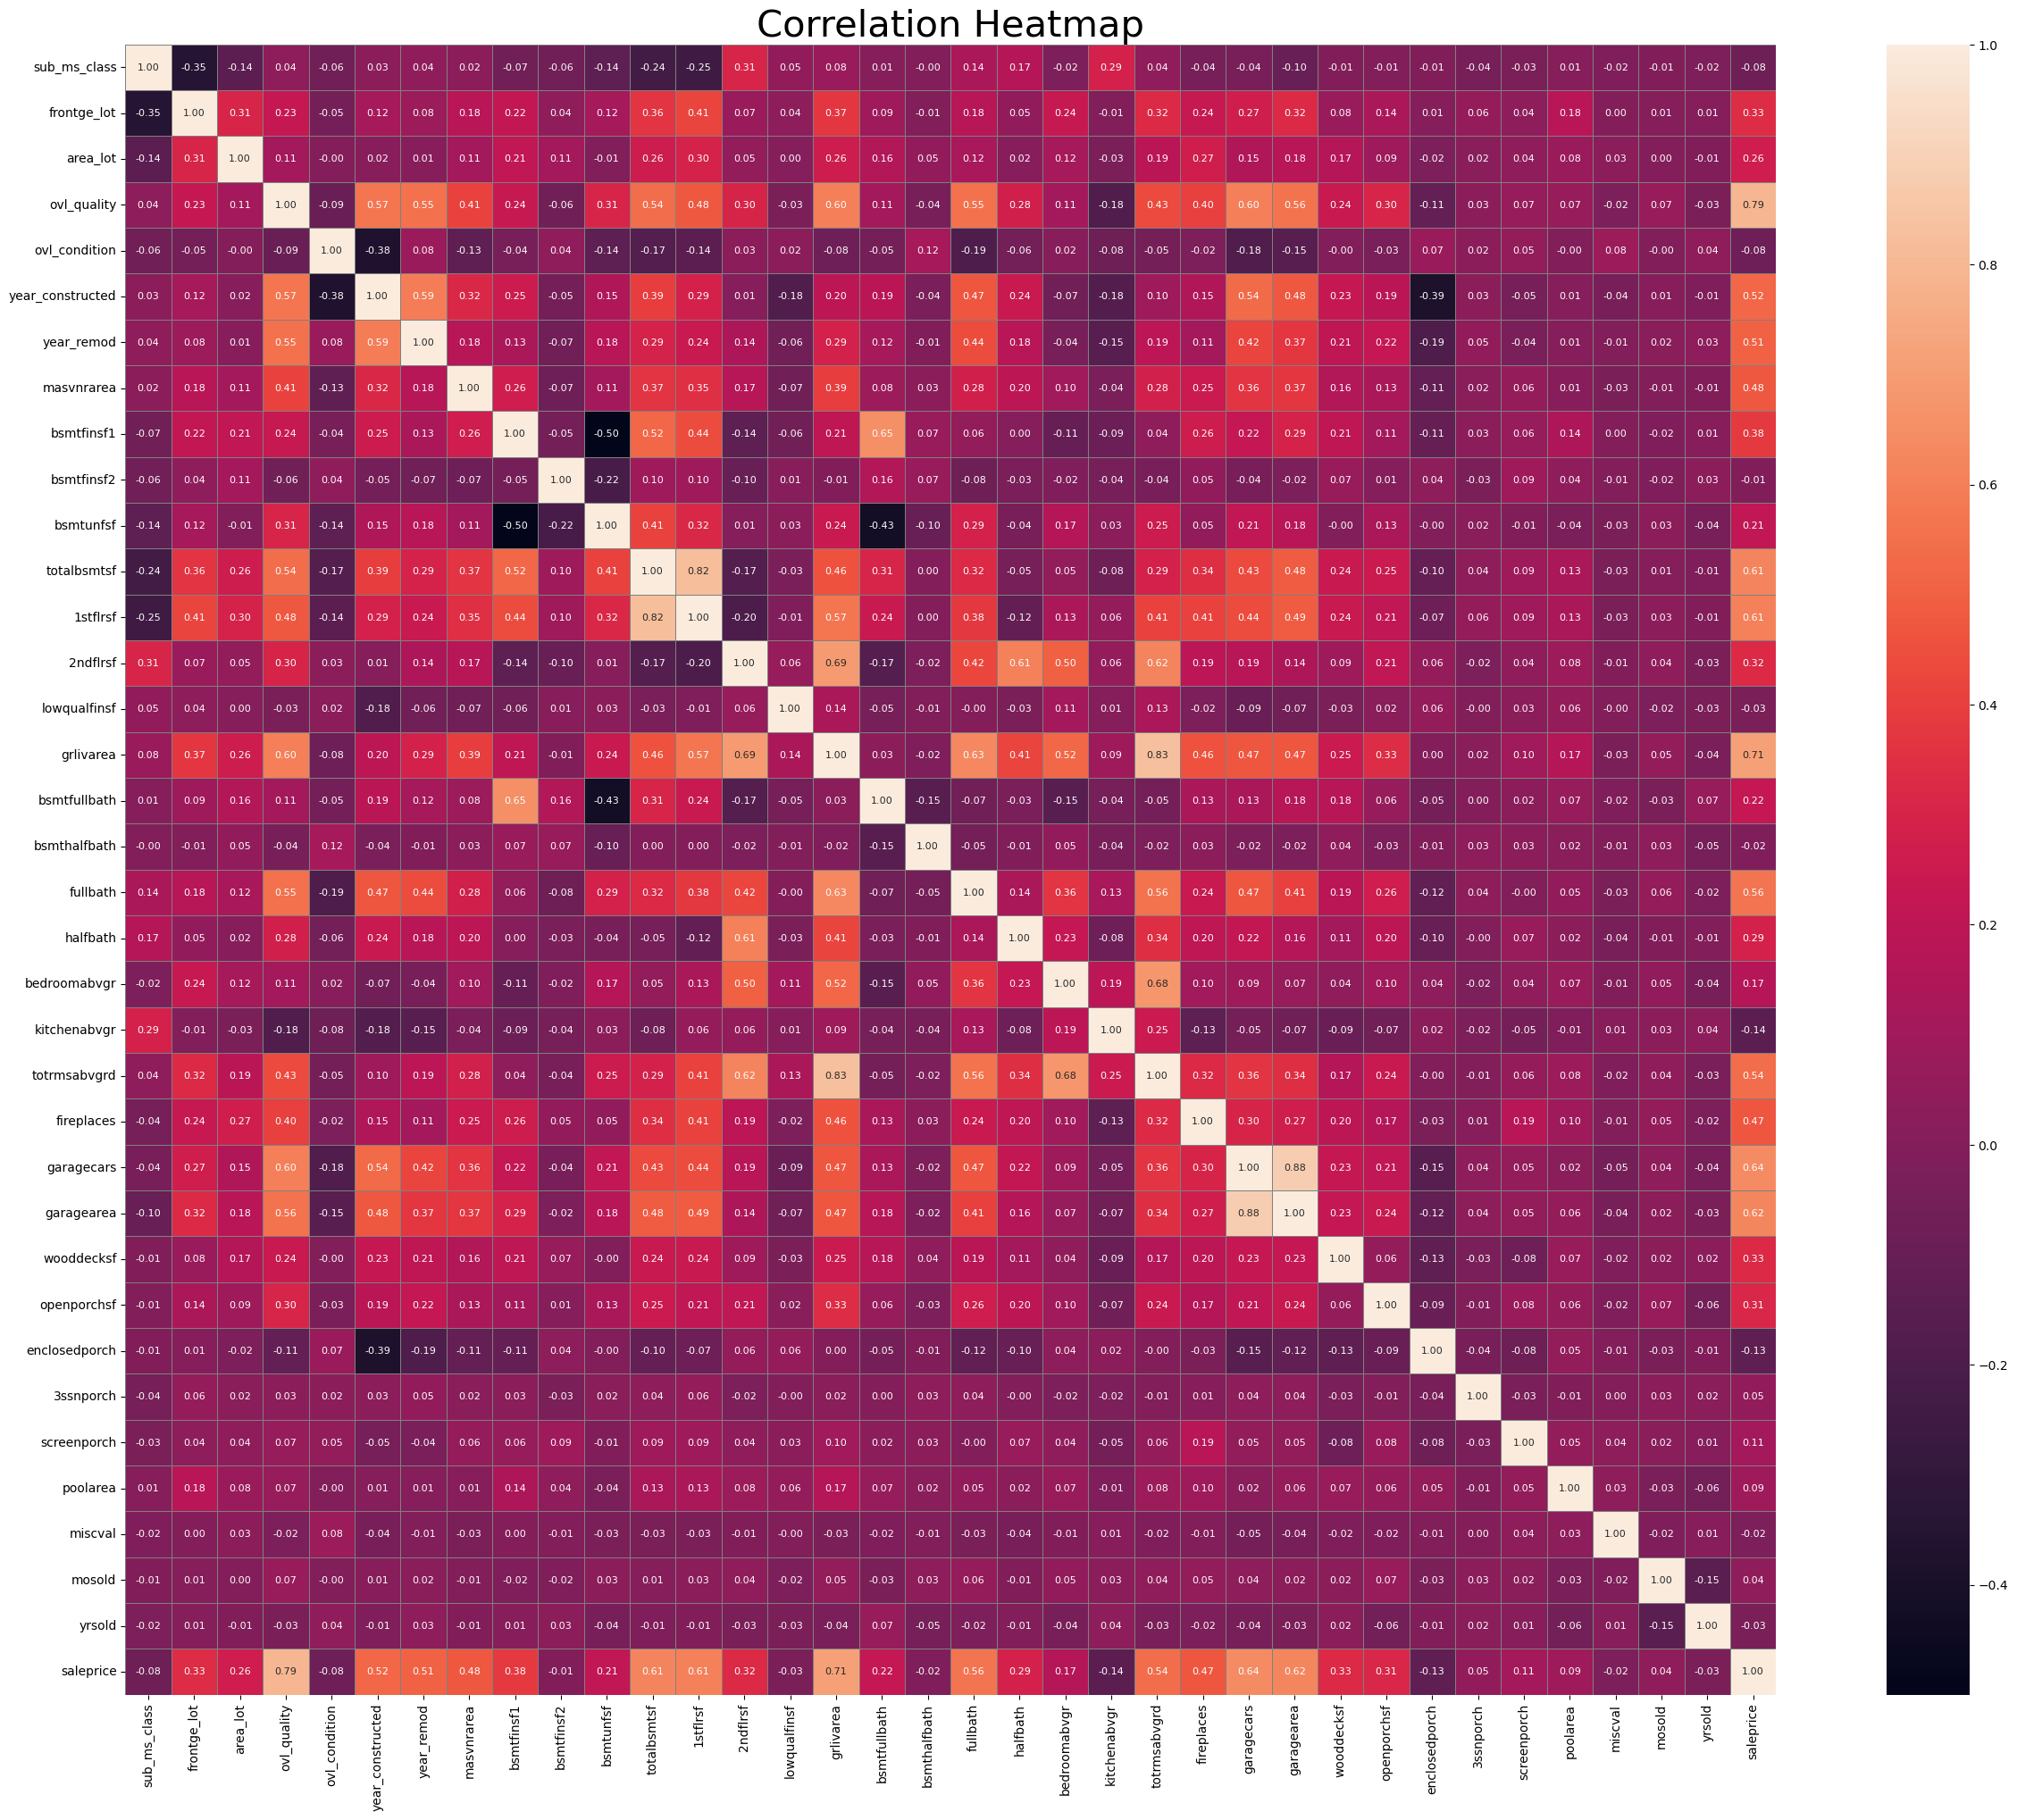

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 24))
sns.heatmap(corr, 
            annot=True, 
            fmt=".2f", 
            square=True, 
            cbar=True, 
            annot_kws={"size": 8},
            linewidths=0.5,
            linecolor='gray')

plt.title('Correlation Heatmap', fontsize=30)
plt.show()